In [2]:
import os
import torch
import torchvision
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#directory where our dataset present
!ls "/content/drive/MyDrive/Colab Notebooks/ NN_Review/dataset-resized"

other  testing	training


In [5]:
data_dir = "/content/drive/MyDrive/Colab Notebooks/ NN_Review/dataset-resized"

print(os.listdir(data_dir)) #folders inside dataset directory

classes = os.listdir(data_dir + "/training")
print(classes) 

['.DS_Store', 'training', 'testing', 'other']
['glass', 'cardboard', 'plastic', 'trash', 'paper', 'metal']


In [6]:
from torchvision.datasets import ImageFolder

from torchvision import transforms
from torchvision.transforms import ToTensor

train_transformations = transforms.Compose([                                                                                 
    transforms.Resize((255,255)), #resize input images to 255,255
    transforms.ToTensor()
])

test_transformations = transforms.Compose([
    transforms.Resize((255,255)), #resize input images to 255,255
    transforms.ToTensor()
])

#applt the train and test transformations
training_dataset = ImageFolder(data_dir+'/training', transform=train_transformations)  
testing_dataset= ImageFolder(data_dir+'/testing', transform=test_transformations)

In [7]:
print(training_dataset.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


Label:  glass (1)


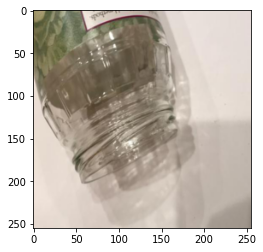

In [8]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: ', training_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0)) #change dimension from 3,255,255 to 255,255,3 for matplotlib 

show_example(*training_dataset[700]) 

In [9]:
#splitting training dataset into train_ds and val_ds 

random_seed = 42
torch.manual_seed(random_seed);

val_size = 600
train_size = len(training_dataset) - val_size

train_ds, val_ds = random_split(training_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(1330, 600)

In [10]:
len(val_ds)

600

In [11]:
val_ds

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


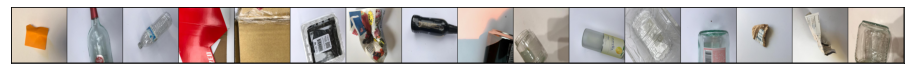

In [12]:
#We can now create data loaders for training and validation, to load the data in batches

from torch.utils.data.dataloader import DataLoader

batch_size=16

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

#We can look at batches of images from the dataset using the `make_grid` method from `torchvision`.

from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_dl)

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
device = get_default_device()
device

device(type='cuda')

In [15]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)


In [16]:
val_dl

In [17]:
import torch.nn as nn
import torch.nn.functional as F

In [18]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

Training the Model

In [19]:
@torch.no_grad() 
def evaluate(model, val_loader):
    model.eval() 
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train() 

        train_losses = [] 

        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item() 
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [20]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [21]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [22]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return training_dataset.classes[preds[0].item()]

resnet 9


In [23]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)] 
    
    if pool: layers.append(nn.MaxPool2d(2)) 
    return nn.Sequential(*layers) 


class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64) 
        self.conv2 = conv_block(64, 128, pool=True) 
        
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
            
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True) 
        
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2), 
                                        nn.Flatten(), 
                                        nn.Linear(512*15*15, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out) 
        
        out = self.res1(out) + out 
        
        out = self.conv3(out) 
        out = self.conv4(out) 
        
        out = self.res2(out) + out 
        
        out = self.classifier(out) 
        return out

In [24]:
model_resnet = to_device(ResNet9(3, 6), device) #num_classes=6
model_resnet

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [25]:
history3 = [evaluate(model_resnet, val_dl)]
history3

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.16502192616462708, 'val_loss': 1.7921007871627808}]

In [26]:
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001

In [27]:
history3 = fit(num_epochs, lr, model_resnet, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 20.3793, val_loss: 37.7677, val_acc: 0.2105
Epoch [1], train_loss: 14.2175, val_loss: 5.4801, val_acc: 0.3602
Epoch [2], train_loss: 8.4792, val_loss: 10.5364, val_acc: 0.4008
Epoch [3], train_loss: 5.5716, val_loss: 10.2204, val_acc: 0.3723
Epoch [4], train_loss: 4.1923, val_loss: 5.3268, val_acc: 0.3717
Epoch [5], train_loss: 4.5788, val_loss: 4.0816, val_acc: 0.3794
Epoch [6], train_loss: 3.0927, val_loss: 3.7772, val_acc: 0.4644
Epoch [7], train_loss: 2.2362, val_loss: 5.6385, val_acc: 0.4605
Epoch [8], train_loss: 2.4110, val_loss: 3.6586, val_acc: 0.4205
Epoch [9], train_loss: 2.1398, val_loss: 3.9243, val_acc: 0.4720
Epoch [10], train_loss: 1.9326, val_loss: 2.5218, val_acc: 0.5115
Epoch [11], train_loss: 1.3340, val_loss: 1.9640, val_acc: 0.5247
Epoch [12], train_loss: 1.2824, val_loss: 2.0392, val_acc: 0.5658
Epoch [13], train_loss: 1.1018, val_loss: 2.2150, val_acc: 0.5362
Epoch [14], train_loss: 0.8439, val_loss: 1.8312, val_acc: 0.6102
Epoch [15], tra

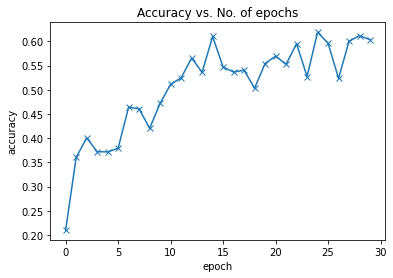

In [28]:
plot_accuracies(history3)

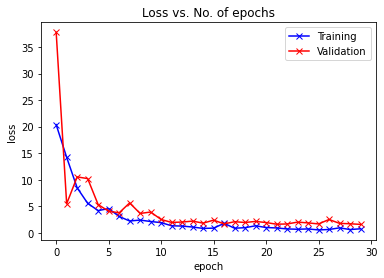

In [29]:
plot_losses(history3)

Label: cardboard , Predicted: cardboard


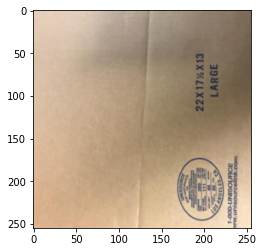

In [30]:
img, label = testing_dataset[76]
plt.imshow(img.permute(1, 2, 0))
print('Label:', training_dataset.classes[label], ', Predicted:', predict_image(img, model_resnet))


Label: glass , Predicted: glass


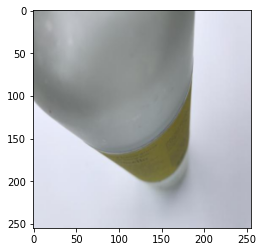

In [31]:
img, label = testing_dataset[150]
plt.imshow(img.permute(1, 2, 0))
print('Label:', training_dataset.classes[label], ', Predicted:', predict_image(img, model_resnet))

Confusion matrix


In [32]:
len(testing_dataset)

597

In [33]:
y=[]
yhat=[]

In [34]:
for i in  range(0,len(testing_dataset)):
  img, label = testing_dataset[i]
  y.append(training_dataset.classes[label])
  yhat.append(predict_image(img, model_resnet))
print(y)
print(yhat)

['cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard'

In [35]:
cm = confusion_matrix(y,yhat)
print(cm)

[[78  4  5  7  6  0]
 [ 2 44 17  5 30  1]
 [ 3 11 59  7 18  1]
 [ 6  7  6 75  6  0]
 [ 5 13  8  9 64  0]
 [10 14 32  8 32  4]]


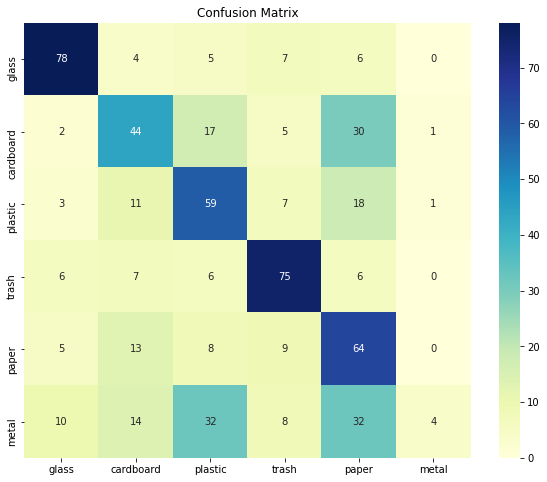

In [36]:
df_cm = pd.DataFrame(cm,classes,classes)

plt.figure(figsize=(10,8))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [37]:
test_loader = DeviceDataLoader(DataLoader(testing_dataset, batch_size*2), device)
result = evaluate(model_resnet, test_loader)
result

{'val_acc': 0.5328947305679321, 'val_loss': 2.469900131225586}

In [38]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer): 
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step() 
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [39]:
evaluate(model_resnet, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.6036184430122375, 'val_loss': 1.5981080532073975}

In [40]:
epochs = 20
max_lr = 0.01
grad_clip = 0.1 
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [41]:
history5 = fit_one_cycle(epochs, max_lr, model_resnet, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.6374, val_loss: 4.3898, val_acc: 0.5751
Epoch [1], train_loss: 6.7736, val_loss: 33.9859, val_acc: 0.2939
Epoch [2], train_loss: 10.2697, val_loss: 37.1783, val_acc: 0.2522
Epoch [3], train_loss: 10.3656, val_loss: 18.3938, val_acc: 0.2303
Epoch [4], train_loss: 10.6656, val_loss: 6.5785, val_acc: 0.2177
Epoch [5], train_loss: 1.9474, val_loss: 1.8228, val_acc: 0.3980
Epoch [6], train_loss: 1.5213, val_loss: 18.3259, val_acc: 0.2538
Epoch [7], train_loss: 1.6354, val_loss: 2.0791, val_acc: 0.4172
Epoch [8], train_loss: 1.1686, val_loss: 2.3402, val_acc: 0.4868
Epoch [9], train_loss: 1.0549, val_loss: 7.1092, val_acc: 0.2911
Epoch [10], train_loss: 1.7780, val_loss: 2.0142, val_acc: 0.5164
Epoch [11], train_loss: 0.9120, val_loss: 1.8562, val_acc: 0.5510
Epoch [12], train_loss: 0.8214, val_loss: 1.8188, val_acc: 0.5143
Epoch [13], train_loss: 0.6957, val_loss: 1.8820, val_acc: 0.5406
Epoch [14], train_loss: 0.6513, val_loss: 2.0727, val_acc: 0.5515
Epoch [15], t

In [42]:
epochs = 5
max_lr = 0.005 
grad_clip = 0.1 
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [43]:
history5 += fit_one_cycle(epochs, max_lr, model_resnet, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.3810, val_loss: 18.8304, val_acc: 0.4698
Epoch [1], train_loss: 10.0943, val_loss: 20.3175, val_acc: 0.4052
Epoch [2], train_loss: 3.0662, val_loss: 5.7371, val_acc: 0.4331
Epoch [3], train_loss: 1.3360, val_loss: 4.5239, val_acc: 0.5554
Epoch [4], train_loss: 0.5938, val_loss: 4.4569, val_acc: 0.5592


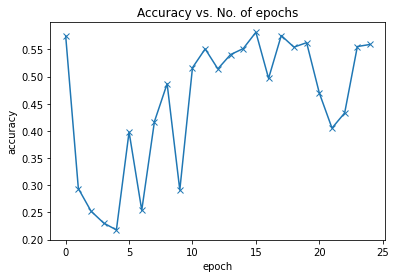

In [44]:
plot_accuracies(history5)

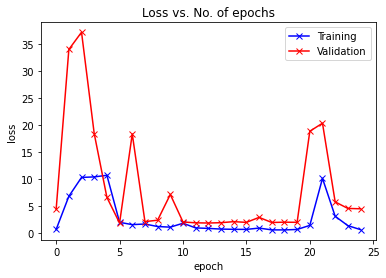

In [45]:
plot_losses(history5)

In [46]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

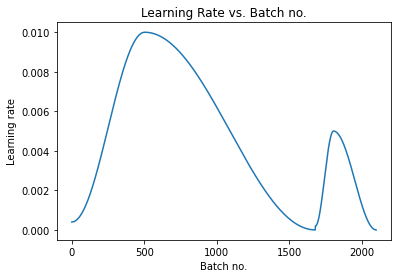

In [47]:
plot_lrs(history5)

In [48]:
test_loader = DeviceDataLoader(DataLoader(testing_dataset, batch_size*2), device)
result = evaluate(model_resnet, test_loader)
result

{'val_acc': 0.4942825734615326, 'val_loss': 5.455424785614014}

In [49]:
path = "/content/drive/My Drive/Colab Notebooks/modelweatherusingresnet9.pth" 
torch.save(model_resnet.state_dict(), path)

resnet 34


In [50]:
import torchvision.models as models

class Resnet34CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet34(pretrained=True)
        
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 6)
         
    def forward(self, xb):
        xb= self.network(xb)
        return xb    
        
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False 
        for param in self.network.fc.parameters():
            param.require_grad = True 
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [51]:
model_resnet34 = to_device(Resnet34CnnModel(), device)
model_resnet34

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Resnet34CnnModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [52]:
evaluate(model_resnet34, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.22587718069553375, 'val_loss': 2.0084831714630127}

In [53]:
model_resnet34.freeze()

epochs = 20
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [54]:
history6 = fit_one_cycle(epochs, max_lr, model_resnet34, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.0730, val_loss: 1.4418, val_acc: 0.5548
Epoch [1], train_loss: 1.0764, val_loss: 2.0465, val_acc: 0.4402
Epoch [2], train_loss: 1.3311, val_loss: 6.9665, val_acc: 0.2495
Epoch [3], train_loss: 1.4131, val_loss: 2.5530, val_acc: 0.2582
Epoch [4], train_loss: 1.5179, val_loss: 2.1089, val_acc: 0.3295
Epoch [5], train_loss: 1.3339, val_loss: 2.3793, val_acc: 0.3706
Epoch [6], train_loss: 1.2568, val_loss: 2.0264, val_acc: 0.3558
Epoch [7], train_loss: 1.1868, val_loss: 1.2632, val_acc: 0.5044
Epoch [8], train_loss: 1.1534, val_loss: 1.5138, val_acc: 0.4550
Epoch [9], train_loss: 1.0820, val_loss: 1.6087, val_acc: 0.4518
Epoch [10], train_loss: 1.0510, val_loss: 1.3326, val_acc: 0.4863
Epoch [11], train_loss: 1.0123, val_loss: 1.7525, val_acc: 0.3432
Epoch [12], train_loss: 0.9147, val_loss: 2.1054, val_acc: 0.4589
Epoch [13], train_loss: 0.8559, val_loss: 1.2117, val_acc: 0.5987
Epoch [14], train_loss: 0.8010, val_loss: 2.5097, val_acc: 0.4666
Epoch [15], train_lo

In [55]:
model_resnet34.unfreeze()

epochs=20
history6 += fit_one_cycle(epochs, 0.001, model_resnet34, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.5318, val_loss: 0.7042, val_acc: 0.7533
Epoch [1], train_loss: 0.4960, val_loss: 0.7254, val_acc: 0.7621
Epoch [2], train_loss: 0.5304, val_loss: 0.7335, val_acc: 0.7281
Epoch [3], train_loss: 0.5460, val_loss: 0.8678, val_acc: 0.6941
Epoch [4], train_loss: 0.6127, val_loss: 0.8615, val_acc: 0.6919
Epoch [5], train_loss: 0.5992, val_loss: 1.0275, val_acc: 0.6519
Epoch [6], train_loss: 0.5693, val_loss: 1.5294, val_acc: 0.5389
Epoch [7], train_loss: 0.5328, val_loss: 0.9398, val_acc: 0.6897
Epoch [8], train_loss: 0.5094, val_loss: 1.4020, val_acc: 0.5800
Epoch [9], train_loss: 0.4543, val_loss: 0.9202, val_acc: 0.6749
Epoch [10], train_loss: 0.4039, val_loss: 1.0548, val_acc: 0.6694
Epoch [11], train_loss: 0.3442, val_loss: 0.8076, val_acc: 0.7325
Epoch [12], train_loss: 0.3119, val_loss: 2.2853, val_acc: 0.4973
Epoch [13], train_loss: 0.2564, val_loss: 0.7851, val_acc: 0.7484
Epoch [14], train_loss: 0.2113, val_loss: 0.8487, val_acc: 0.7445
Epoch [15], train_lo

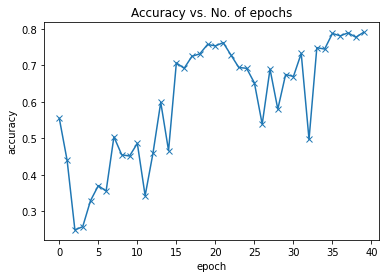

In [56]:
plot_accuracies(history6)

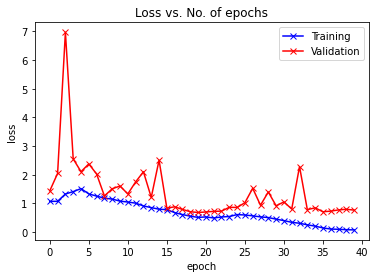

In [57]:
plot_losses(history6)

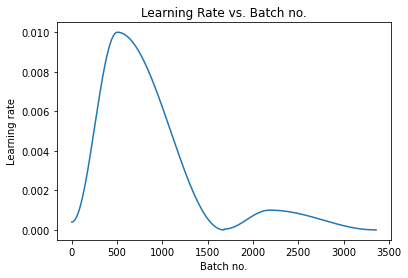

In [58]:
plot_lrs(history6)

In [59]:
test_loader = DeviceDataLoader(DataLoader(testing_dataset, batch_size*2), device)
result = evaluate(model_resnet34, test_loader)
result

{'val_acc': 0.6999529600143433, 'val_loss': 1.430235505104065}

In [60]:
path = "/content/drive/My Drive/Colab Notebooks/modelweatherusingresnet34.pth" 
torch.save(model_resnet34.state_dict(), path)

In [61]:
model_resnet34 = to_device(Resnet34CnnModel(), device)
model_resnet34.load_state_dict(torch.load("/content/drive/My Drive/Colab Notebooks/modelweatherusingresnet34.pth"))

<All keys matched successfully>

In [62]:
test_loader = DeviceDataLoader(DataLoader(testing_dataset, batch_size*2), device)
evaluate(model_resnet34, test_loader)

{'val_acc': 0.6999529600143433, 'val_loss': 1.430235505104065}

Label: cardboard , Predicted: cardboard


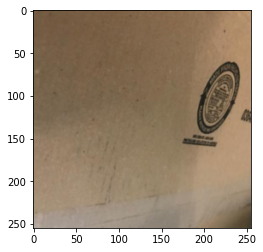

In [63]:
img, label = testing_dataset[75]
plt.imshow(img.permute(1, 2, 0))
print('Label:', training_dataset.classes[label], ', Predicted:', predict_image(img, model_resnet34))

Label: glass , Predicted: glass


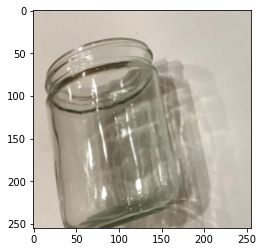

In [64]:
img, label = testing_dataset[125]
plt.imshow(img.permute(1, 2, 0))
print('Label:', training_dataset.classes[label], ', Predicted:', predict_image(img, model_resnet34))

In [65]:
y=[]
yhat=[]

In [66]:
for i in  range(0,len(testing_dataset)):
  img, label = testing_dataset[i]
  y.append(training_dataset.classes[label])
  yhat.append(predict_image(img, model_resnet34))
print(y)
print(yhat)

['cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard'

In [67]:
cm = confusion_matrix(y,yhat)
print(cm)

[[91  1  0  5  3  0]
 [ 0 88  5  2  4  0]
 [ 1 19 68  6  5  0]
 [ 2  0  2 93  3  0]
 [ 2 23  3  4 67  0]
 [ 8 13 15 35 12 17]]


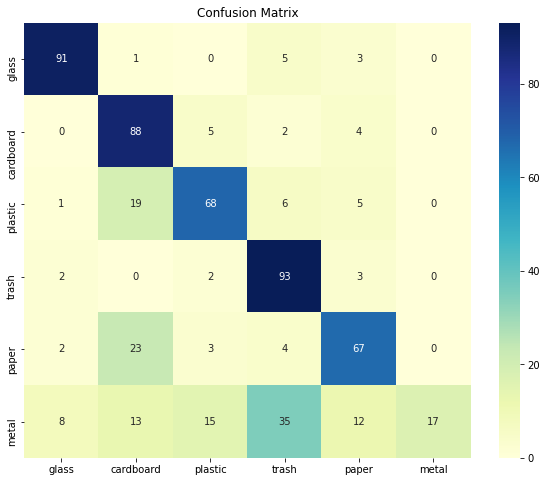

In [68]:
df_cm = pd.DataFrame(cm,classes,classes)

plt.figure(figsize=(10,8))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

resnet 18



In [167]:
import torchvision.models as models

class resnet18CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet18(pretrained=True)
        
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 6)
         
    def forward(self, xb):
        xb= self.network(xb)
        return xb    
        
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False 
        for param in self.network.fc.parameters():
            param.require_grad = True 
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [168]:
model_resnet18 = to_device(resnet18CnnModel(), device)
model_resnet18

resnet18CnnModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [169]:
evaluate(model_resnet18, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.23135963082313538, 'val_loss': 1.846152901649475}

In [170]:
model_resnet18.freeze()

epochs = 20
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [171]:
history7 = fit_one_cycle(epochs, max_lr, model_resnet18, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.9669, val_loss: 3.1017, val_acc: 0.3755
Epoch [1], train_loss: 1.0949, val_loss: 5.7128, val_acc: 0.2670
Epoch [2], train_loss: 1.4731, val_loss: 1.9120, val_acc: 0.3728
Epoch [3], train_loss: 1.6075, val_loss: 59.0685, val_acc: 0.2692
Epoch [4], train_loss: 1.5748, val_loss: 1.4644, val_acc: 0.4117
Epoch [5], train_loss: 1.4524, val_loss: 1.7010, val_acc: 0.3169
Epoch [6], train_loss: 1.3840, val_loss: 1.4097, val_acc: 0.4052
Epoch [7], train_loss: 1.2914, val_loss: 48.4292, val_acc: 0.1678
Epoch [8], train_loss: 1.2767, val_loss: 2.5673, val_acc: 0.2928
Epoch [9], train_loss: 1.2333, val_loss: 1.5140, val_acc: 0.3503
Epoch [10], train_loss: 1.2329, val_loss: 1.6228, val_acc: 0.3558
Epoch [11], train_loss: 1.1207, val_loss: 1.4343, val_acc: 0.4709
Epoch [12], train_loss: 1.1254, val_loss: 1.1528, val_acc: 0.5499
Epoch [13], train_loss: 1.0783, val_loss: 1.1893, val_acc: 0.5110
Epoch [14], train_loss: 0.9926, val_loss: 1.2576, val_acc: 0.5269
Epoch [15], train_

In [172]:
model_resnet18.unfreeze()

epochs=20
history7 += fit_one_cycle(epochs, 0.001, model_resnet18, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.6829, val_loss: 0.7573, val_acc: 0.7303
Epoch [1], train_loss: 0.6751, val_loss: 0.7865, val_acc: 0.7182
Epoch [2], train_loss: 0.6837, val_loss: 0.9944, val_acc: 0.6420
Epoch [3], train_loss: 0.6960, val_loss: 1.0556, val_acc: 0.6146
Epoch [4], train_loss: 0.6868, val_loss: 1.0015, val_acc: 0.6332
Epoch [5], train_loss: 0.7144, val_loss: 1.5836, val_acc: 0.5696
Epoch [6], train_loss: 0.6680, val_loss: 1.6065, val_acc: 0.4978
Epoch [7], train_loss: 0.6681, val_loss: 1.2521, val_acc: 0.5696
Epoch [8], train_loss: 0.6212, val_loss: 1.3434, val_acc: 0.6058
Epoch [9], train_loss: 0.5582, val_loss: 1.1846, val_acc: 0.6036
Epoch [10], train_loss: 0.5012, val_loss: 0.8055, val_acc: 0.7314
Epoch [11], train_loss: 0.4569, val_loss: 0.7262, val_acc: 0.7357
Epoch [12], train_loss: 0.3860, val_loss: 0.9167, val_acc: 0.7253
Epoch [13], train_loss: 0.3737, val_loss: 0.7690, val_acc: 0.7357
Epoch [14], train_loss: 0.2728, val_loss: 0.7409, val_acc: 0.7484
Epoch [15], train_lo

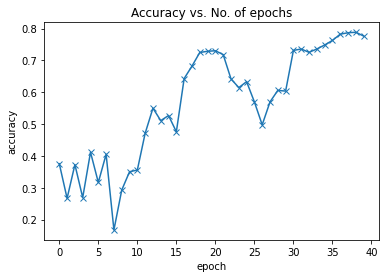

In [173]:
plot_accuracies(history7)

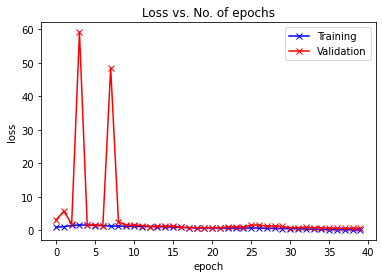

In [174]:
plot_losses(history7)

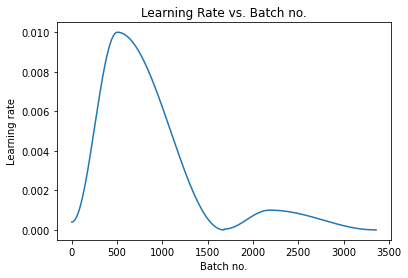

In [175]:
plot_lrs(history7)

In [176]:
test_loader = DeviceDataLoader(DataLoader(testing_dataset, batch_size*2), device)
result = evaluate(model_resnet18, test_loader)
result

{'val_acc': 0.722196102142334, 'val_loss': 1.153548240661621}

In [177]:
path = "/content/drive/My Drive/Colab Notebooks/modelweatherusingresnet18.pth" 
torch.save(model_resnet18.state_dict(), path)

In [178]:
model_resnet18 = to_device(resnet18CnnModel(), device)
model_resnet18.load_state_dict(torch.load("/content/drive/My Drive/Colab Notebooks/modelweatherusingresnet18.pth"))

<All keys matched successfully>

In [179]:
test_loader = DeviceDataLoader(DataLoader(testing_dataset, batch_size*2), device)
evaluate(model_resnet18, test_loader)

{'val_acc': 0.722196102142334, 'val_loss': 1.153548240661621}

Label: paper , Predicted: paper


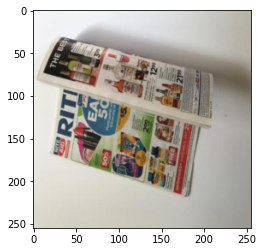

In [180]:
img, label = testing_dataset[375]
plt.imshow(img.permute(1, 2, 0))
print('Label:', training_dataset.classes[label], ', Predicted:', predict_image(img, model_resnet18))

In [181]:
y=[]
yhat=[]

In [182]:
for i in  range(0,len(testing_dataset)):
  img, label = testing_dataset[i]
  y.append(training_dataset.classes[label])
  yhat.append(predict_image(img, model_resnet18))
print(y)
print(yhat)

['cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard'

In [183]:
cm = confusion_matrix(y,yhat)
print(cm)

[[97  0  0  2  1  0]
 [ 0 87  4  1  6  1]
 [ 2 14 71  4  6  2]
 [ 3  0  1 91  5  0]
 [ 3 18  0  6 72  0]
 [ 9  8 16 21 27 19]]


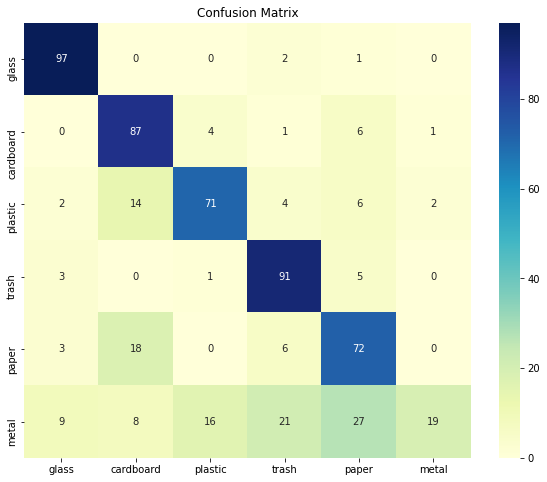

In [184]:
df_cm = pd.DataFrame(cm,classes,classes)

plt.figure(figsize=(10,8))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

resnet 50


In [185]:
import torchvision.models as models

class resnet50CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet50(pretrained=True)
        
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 6)
         
    def forward(self, xb):
        xb= self.network(xb)
        return xb    
        
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False 
        for param in self.network.fc.parameters():
            param.require_grad = True 
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [186]:
model_resnet50 = to_device(resnet50CnnModel(), device)
model_resnet50

resnet50CnnModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [187]:
evaluate(model_resnet50, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.26206138730049133, 'val_loss': 1.783449649810791}

In [188]:
model_resnet50.freeze()

epochs = 20
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [189]:
history8 = fit_one_cycle(epochs, max_lr, model_resnet50, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.1055, val_loss: 3.6226, val_acc: 0.3635
Epoch [1], train_loss: 1.2626, val_loss: 16.6935, val_acc: 0.1842
Epoch [2], train_loss: 1.2463, val_loss: 1.6604, val_acc: 0.4019
Epoch [3], train_loss: 1.2847, val_loss: 1.5593, val_acc: 0.4035
Epoch [4], train_loss: 1.2380, val_loss: 2.3233, val_acc: 0.3843
Epoch [5], train_loss: 1.1503, val_loss: 1.1903, val_acc: 0.5351
Epoch [6], train_loss: 1.1323, val_loss: 2.2565, val_acc: 0.3799
Epoch [7], train_loss: 1.0592, val_loss: 1.4995, val_acc: 0.4167
Epoch [8], train_loss: 1.1063, val_loss: 1.4491, val_acc: 0.4073
Epoch [9], train_loss: 1.0539, val_loss: 1.5236, val_acc: 0.4912
Epoch [10], train_loss: 0.9873, val_loss: 2.0668, val_acc: 0.3882
Epoch [11], train_loss: 1.0163, val_loss: 1.2907, val_acc: 0.4868
Epoch [12], train_loss: 0.9435, val_loss: 1.0072, val_acc: 0.6223
Epoch [13], train_loss: 0.8407, val_loss: 1.1612, val_acc: 0.5636
Epoch [14], train_loss: 0.7609, val_loss: 1.4074, val_acc: 0.5137
Epoch [15], train_l

In [190]:
model_resnet50.unfreeze()

epochs=20
history8 += fit_one_cycle(epochs, 0.001, model_resnet50, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.4718, val_loss: 0.8026, val_acc: 0.7127
Epoch [1], train_loss: 0.4439, val_loss: 0.7710, val_acc: 0.7122
Epoch [2], train_loss: 0.4601, val_loss: 0.8236, val_acc: 0.7281
Epoch [3], train_loss: 0.5181, val_loss: 0.9599, val_acc: 0.6804
Epoch [4], train_loss: 0.5158, val_loss: 0.8073, val_acc: 0.7303
Epoch [5], train_loss: 0.4867, val_loss: 1.4427, val_acc: 0.5762
Epoch [6], train_loss: 0.5022, val_loss: 1.0874, val_acc: 0.6140
Epoch [7], train_loss: 0.4877, val_loss: 0.9016, val_acc: 0.6985
Epoch [8], train_loss: 0.4599, val_loss: 0.9217, val_acc: 0.6908
Epoch [9], train_loss: 0.3497, val_loss: 1.1182, val_acc: 0.6491
Epoch [10], train_loss: 0.3613, val_loss: 1.0317, val_acc: 0.6612
Epoch [11], train_loss: 0.3024, val_loss: 0.8025, val_acc: 0.7330
Epoch [12], train_loss: 0.2461, val_loss: 1.2777, val_acc: 0.6069
Epoch [13], train_loss: 0.2067, val_loss: 0.8278, val_acc: 0.7346
Epoch [14], train_loss: 0.1677, val_loss: 0.7793, val_acc: 0.7533
Epoch [15], train_lo

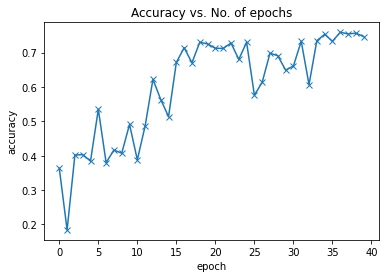

In [191]:
plot_accuracies(history8)

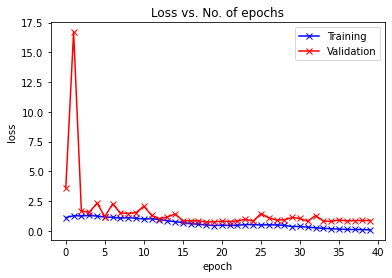

In [192]:
plot_losses(history8)

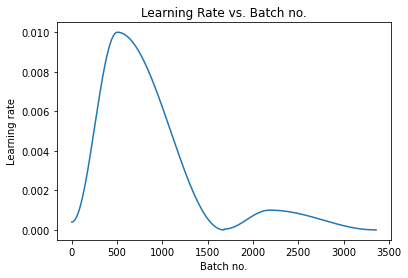

In [193]:
plot_lrs(history8)

In [194]:
test_loader = DeviceDataLoader(DataLoader(testing_dataset, batch_size*2), device)
result = evaluate(model_resnet50, test_loader)
result

{'val_acc': 0.6546835899353027, 'val_loss': 1.30921471118927}

In [195]:
path = "/content/drive/My Drive/Colab Notebooks/modelweatherusingresnet50.pth" 
torch.save(model_resnet50.state_dict(), path)

In [196]:
model_resnet50 = to_device(resnet50CnnModel(), device)
model_resnet50.load_state_dict(torch.load("/content/drive/My Drive/Colab Notebooks/modelweatherusingresnet50.pth"))

<All keys matched successfully>

In [197]:
test_loader = DeviceDataLoader(DataLoader(testing_dataset, batch_size*2), device)
evaluate(model_resnet50, test_loader)

{'val_acc': 0.6546835899353027, 'val_loss': 1.30921471118927}

Label: plastic , Predicted: plastic


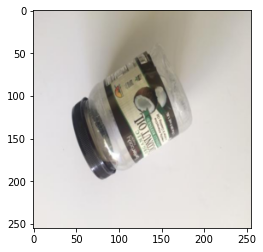

In [198]:
img, label = testing_dataset[432]
plt.imshow(img.permute(1, 2, 0))
print('Label:', training_dataset.classes[label], ', Predicted:', predict_image(img, model_resnet50))

In [199]:
y=[]
yhat=[]

In [200]:
for i in  range(0,len(testing_dataset)):
  img, label = testing_dataset[i]
  y.append(training_dataset.classes[label])
  yhat.append(predict_image(img, model_resnet50))
print(y)
print(yhat)

['cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard'

In [201]:
cm = confusion_matrix(y,yhat)
print(cm)

[[85  1  1 11  2  0]
 [ 0 74 12  2 10  1]
 [ 1 15 71  6  4  2]
 [ 1  1  4 88  6  0]
 [ 2 19  2  5 71  0]
 [10 11 13 36 22  8]]


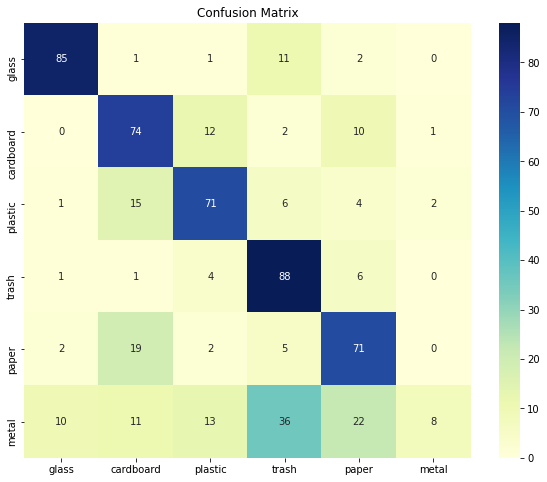

In [202]:
df_cm = pd.DataFrame(cm,classes,classes)

plt.figure(figsize=(10,8))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")